In [1]:
import pandas as pd
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset, WeightedRandomSampler
import torch.nn.functional as F
# Đọc file CSV thành DataFrame
df = pd.read_csv("top50_daily.csv")
df.head()


,STT,TEXT,COUNT,VIDEO
0,1,thương yêu,6,"W03373B.mp4, W03373N.mp4, W03373T.mp4, W03450B..."
1,2,đặc biệt,4,"W01122B.mp4, W01122T.mp4, W01122N.mp4, W01122.mp4"
2,3,thành lập,4,"W03175N.mp4, W03175T.mp4, W03175B.mp4, W03175.mp4"
3,4,thường xuyên,4,"D0156N.mp4, D0156B.mp4, D0156.mp4, D0156T.mp4"
4,5,tưởng tượng,4,"W03732T.mp4, W03732.mp4, W03732N.mp4, W03732B.mp4"


In [2]:
df[["TEXT", "VIDEO"]]

,TEXT,VIDEO
0,thương yêu,"W03373B.mp4, W03373N.mp4, W03373T.mp4, W03450B..."
1,đặc biệt,"W01122B.mp4, W01122T.mp4, W01122N.mp4, W01122.mp4"
2,thành lập,"W03175N.mp4, W03175T.mp4, W03175B.mp4, W03175.mp4"
3,thường xuyên,"D0156N.mp4, D0156B.mp4, D0156.mp4, D0156T.mp4"
4,tưởng tượng,"W03732T.mp4, W03732.mp4, W03732N.mp4, W03732B.mp4"
5,bộ đội,"W00328N.mp4, W00328T.mp4, W00328B.mp4"
6,bình thường,"W00286N.mp4, W00286B.mp4, W00286T.mp4"
7,sữa bột,"W03037T.mp4, W03037B.mp4, W03037N.mp4"
8,sữa dê,"W03038N.mp4, W03038T.mp4, W03038B.mp4"
9,sữa bò,"W03036T.mp4, W03036B.mp4, W03036N.mp4"


In [3]:
for i in df.index:
    files = [x.strip() for x in df.loc[i, "VIDEO"].split(",")]
    print(f"Processing row {i}: {files}")

Processing row 0: ['W03373B.mp4', 'W03373N.mp4', 'W03373T.mp4', 'W03450B.mp4', 'W03450T.mp4', 'W03450N.mp4']
Processing row 1: ['W01122B.mp4', 'W01122T.mp4', 'W01122N.mp4', 'W01122.mp4']
Processing row 2: ['W03175N.mp4', 'W03175T.mp4', 'W03175B.mp4', 'W03175.mp4']
Processing row 3: ['D0156N.mp4', 'D0156B.mp4', 'D0156.mp4', 'D0156T.mp4']
Processing row 4: ['W03732T.mp4', 'W03732.mp4', 'W03732N.mp4', 'W03732B.mp4']
Processing row 5: ['W00328N.mp4', 'W00328T.mp4', 'W00328B.mp4']
Processing row 6: ['W00286N.mp4', 'W00286B.mp4', 'W00286T.mp4']
Processing row 7: ['W03037T.mp4', 'W03037B.mp4', 'W03037N.mp4']
Processing row 8: ['W03038N.mp4', 'W03038T.mp4', 'W03038B.mp4']
Processing row 9: ['W03036T.mp4', 'W03036B.mp4', 'W03036N.mp4']
Processing row 10: ['W00304N.mp4', 'W00304B.mp4', 'W00304T.mp4']
Processing row 11: ['W03011B.mp4', 'W03011T.mp4', 'W03011N.mp4']
Processing row 12: ['W00326B.mp4', 'W00326T.mp4', 'W00326N.mp4']
Processing row 13: ['W00459T.mp4', 'W00459N.mp4', 'W00459B.mp4']
Pro

In [4]:
#shape of vid:
cap = cv2.VideoCapture("Dataset/Video/D0001B.mp4")
if not cap.isOpened():
    print("Error: Could not open video.")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"Video shape: {width}x{height}, FPS: {fps}")

Video shape: 1280x720, FPS: 29.97002997002997


In [5]:
def draw_keypoints(frame, keypoints):
    for point in keypoints:
        x, y = int(point[0] * frame.shape[1]), int(point[1] * frame.shape[0])
        cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)
    return frame

In [6]:
import cv2

def extract_frame(video_path: str, n: int, save_path: str | None = None):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Không mở được {video_path}")

    # Nhảy tới khung thứ n (đếm từ 0)
    cap.set(cv2.CAP_PROP_POS_FRAMES, n)

    ret, frame = cap.read()
    cap.release()

    if not ret:
        raise ValueError(f"Khung {n} > tổng số khung của video")

    if save_path:
        cv2.imwrite(save_path, frame)   # lưu ra file ảnh
    return frame                       # hoặc trả về mảng numpy


In [ ]:
import mediapipe as mp
from config import Config
from detector import MediaPipeProcessor

pose = MediaPipeProcessor(Config())
results = []
def extract_video_keypoint(video_path):
    keypoints = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        _, result = pose.process_frame(image_rgb)
        frame_keypoints = pose.extract_keypoints(result)
        results.append(result)
        keypoints.append(frame_keypoints)
    cap.release()
    return keypoints, results

2025-06-22 03:00:47.860851: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 03:00:47.873205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750536047.888554   29971 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750536047.892840   29971 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-22 03:00:47.908363: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [8]:
kpts, res = extract_video_keypoint("Dataset/Video/D0001B.mp4")
kpts

[array([[0.50105268, 0.28799707],
        [0.51235807, 0.25835687],
        [0.51846504, 0.25892198],
        [0.52515322, 0.25971293],
        [0.49177089, 0.25948477],
        [0.48476356, 0.26053023],
        [0.4782576 , 0.26152396],
        [0.53702515, 0.28010911],
        [0.46811682, 0.2816394 ],
        [0.51467562, 0.32350427],
        [0.48807755, 0.32205766],
        [0.59488791, 0.48611197],
        [0.41214603, 0.47078454],
        [0.60808134, 0.72349715],
        [0.37936622, 0.69869858],
        [0.61198318, 0.9463625 ],
        [0.37908462, 0.92722213],
        [0.61266702, 1.0142417 ],
        [0.3753522 , 1.00015116],
        [0.5974108 , 1.01502156],
        [0.39087865, 0.99273908],
        [0.59285903, 0.98984474],
        [0.39510158, 0.96399885],
        [0.55159992, 0.92707992],
        [0.44485611, 0.92623502],
        [0.54123628, 1.24833441],
        [0.431501  , 1.23686743],
        [0.53630501, 1.51688945],
        [0.43160191, 1.51081324],
        [0.536

In [9]:
for i, label, file_name in zip(df.index, df["TEXT"], df["VIDEO"]):
    files = [x.strip() for x in file_name.split(",")]
    for file in files:
        print(f"Processing row {i}: {label} {file}")

Processing row 0: thương yêu W03373B.mp4
Processing row 0: thương yêu W03373N.mp4
Processing row 0: thương yêu W03373T.mp4
Processing row 0: thương yêu W03450B.mp4
Processing row 0: thương yêu W03450T.mp4
Processing row 0: thương yêu W03450N.mp4
Processing row 1: đặc biệt W01122B.mp4
Processing row 1: đặc biệt W01122T.mp4
Processing row 1: đặc biệt W01122N.mp4
Processing row 1: đặc biệt W01122.mp4
Processing row 2: thành lập W03175N.mp4
Processing row 2: thành lập W03175T.mp4
Processing row 2: thành lập W03175B.mp4
Processing row 2: thành lập W03175.mp4
Processing row 3: thường xuyên D0156N.mp4
Processing row 3: thường xuyên D0156B.mp4
Processing row 3: thường xuyên D0156.mp4
Processing row 3: thường xuyên D0156T.mp4
Processing row 4: tưởng tượng W03732T.mp4
Processing row 4: tưởng tượng W03732.mp4
Processing row 4: tưởng tượng W03732N.mp4
Processing row 4: tưởng tượng W03732B.mp4
Processing row 5: bộ đội W00328N.mp4
Processing row 5: bộ đội W00328T.mp4
Processing row 5: bộ đội W00328B

In [10]:
# import numpy as np

# for i, file_names in zip(df.index, df["VIDEO"]):
#     print(f"Processing row {i}: {file_names}")
#     files = [x.strip() for x in file_names.split(",")]
#     for file in files:
#         video_path = f"data/Video_60frames/{file}"
#         keypoints, _ = extract_video_keypoint(video_path)
#         file_name = file.split(".")[0]
#         np.save(f"data/Keypoints/{file_name}.npy", keypoints)
#         print(f"Saved keypoints for {file} to data/keypoints/{file_name}.npy", len(keypoints))
        

In [11]:
class LoadData(Dataset):
    """
    Dataset that selects frames at indices [offset, offset+5, offset+10, ...]
    without truncation. Returns raw sequence per sample.
    Keypoints loaded from keypoints_dir (.npy shape: (T, F)).
    Labels loaded from label_dir   (.npy shape: (T,)).
    """
    def __init__(self, keypoints_dir, label_dir, offset):
        self.keypoints_dir = keypoints_dir
        self.label_dir = label_dir
        self.offset = offset
        # find common base filenames
        kp_files = {os.path.splitext(f)[0] for f in os.listdir(keypoints_dir) if f.endswith('.npy')}
        lbl_files = {os.path.splitext(f)[0] for f in os.listdir(label_dir)   if f.endswith('.npy')}
        self.common = sorted(kp_files & lbl_files)

    def __len__(self):
        return len(self.common)

    def __getitem__(self, idx):
        base = self.common[idx]
        # load full sequences
        kp_seq = np.load(os.path.join(self.keypoints_dir, f"{base}.npy"))  # (T, F)
        lbl_seq= np.load(os.path.join(self.label_dir,   f"{base}.npy"))   # (T,)
        # select every 5th frame starting at offset
        seq_kp = kp_seq[self.offset::5]
        seq_lbl= lbl_seq[self.offset::5]
        # convert to tensors directly (length may vary per sample)
        return torch.from_numpy(seq_kp).float(), torch.from_numpy(seq_lbl).long()

In [12]:
def create_dataloaders(keypoints_dir, label_dir, batch_size=32):
    """
    Creates train and validation DataLoaders padded to the max sequence length across the entire dataset.
    Offsets 0-3 for train, offset 4 for val. No truncation; pad at beginning.
    """
    # instantiate datasets for each offset
    train_datasets = [LoadData(keypoints_dir, label_dir, offs) for offs in range(4)]
    val_dataset    = LoadData(keypoints_dir, label_dir, 4)
    train_ds = ConcatDataset(train_datasets)

    # compute global max length across both train and val
    all_ds = ConcatDataset(train_datasets + [val_dataset])
    max_len = 0
    for kp, _ in all_ds:
        if kp.shape[0] > max_len:
            max_len = kp.shape[0]

    # custom collate function
    def collate_pad_to_max(batch):
        kp_seqs, lbl_seqs = zip(*batch)
        F = kp_seqs[0].shape[1]
        kp_batch, lbl_batch = [], []
        for kp_seq, lbl_seq in zip(kp_seqs, lbl_seqs):
            L = kp_seq.shape[0]
            pad_count = max_len - L

            if pad_count > 0:
                pad_shape = (pad_count, *kp_seq.shape[1:])  
                pad_kp = torch.zeros(pad_shape, dtype=kp_seq.dtype, device=kp_seq.device)
                pad_lbl = torch.zeros((pad_count,), dtype=lbl_seq.dtype, device=lbl_seq.device)
                kp_seq = torch.cat([pad_kp, kp_seq], dim=0)
                lbl_seq = torch.cat([pad_lbl, lbl_seq], dim=0)
            kp_batch.append(kp_seq)
            lbl_batch.append(lbl_seq)
        kp_batch = torch.stack(kp_batch, dim=0)  # (B, max_len, F)
        lbl_batch= torch.stack(lbl_batch, dim=0) # (B, max_len)
        return kp_batch, lbl_batch

    # DataLoaders
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_pad_to_max
    )
    train_labels = []
    for seq, lbl in train_loader:
        # lbl có shape (batch_size, T), nhãn cuối cùng của mỗi sequence là lbl[i, -1]
        for i in range(lbl.shape[0]):
            train_labels.append(int(lbl[i, -1].item()))

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_pad_to_max
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_pad_to_max
    )
    return train_loader, val_loader, max_len

In [13]:
kp_dir = 'data/Keypoints_TCN'
lbl_dir= 'data/Labels'
train_loader, val_loader, global_max_len = create_dataloaders(
    kp_dir, lbl_dir, batch_size=32
)
print(f"Global max sequence length: {global_max_len}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")

# Inspect first batch
for kp_batch, lbl_batch in train_loader:
    print(f"Batch keypoints shape: {kp_batch.shape}")  # (B, global_max_len, F)
    print(f"Batch labels shape:    {lbl_batch.shape}")  # (B, global_max_len)
    break

Global max sequence length: 39
Train batches: 20
Val batches:   5
Batch keypoints shape: torch.Size([32, 39, 150])
Batch labels shape:    torch.Size([32, 39])


In [ ]:
class LSTMClassifier(nn.Module):
    """
    LSTM classifier for sequences of flat keypoint features.
    Input: (batch_size, window_size, feature_size)
    Uses the last hidden state for classification.
    """
    def __init__(
        self,
        feature_size: int,
        hidden_size: int,
        num_layers: int,
        num_classes: int,
        bidirectional: bool = False,
        dropout: float = 0.5
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=feature_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.dropout = nn.Dropout(dropout)
        fc_dim = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(fc_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch_size, window_size, feature_size)
        out, (hn, _) = self.lstm(x)
        if self.lstm.bidirectional:
            final = torch.cat([hn[-2], hn[-1]], dim=1)
        else:
            final = hn[-1]
        final = self.dropout(final)
        return self.fc(final)

In [15]:
def train(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    window_size: int = 15,
    num_epochs: int = 10
):
    """
    Train the model using sliding windows and evaluate on validation set each epoch.
    """
    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(1, num_epochs + 1):
        # --- Training Phase ---
        model.train()
        total_loss = 0.0
        total_windows = 0
        for seqs, lbls in train_loader:
            seqs, lbls = seqs.to(device), lbls.to(device)
            B, T, F = seqs.shape
            if T < window_size:
                continue
            windows = seqs.unfold(1, window_size, 1)
            num_windows = windows.size(1)
            windows = windows.contiguous().view(-1, window_size, F)
            targets = lbls[:, window_size - 1:].contiguous().view(-1)

            # zero gradients
            optimizer.zero_grad()
            logits = model(windows)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * windows.size(0)
            total_windows += windows.size(0)

        train_loss = total_loss / total_windows
                # Compute training accuracy excluding class 0
        correct, total = 0, 0
        with torch.no_grad():
            for seqs, lbls in train_loader:
                seqs, lbls = seqs.to(device), lbls.to(device)
                B, T, F = seqs.shape
                if T < window_size: continue
                windows = seqs.unfold(1, window_size, 1).contiguous().view(-1, window_size, F)
                targets = lbls[:, window_size-1:].contiguous().view(-1)
                logits = model(windows)
                preds = torch.argmax(logits, dim=1)
                # Only count non-zero targets
                mask = targets > 0
                correct += ((preds == targets) & mask).sum().item()
                total += mask.sum().item()
        train_acc = correct / total if total > 1 else 0
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # --- Validation Phase ---
        model.eval()
        val_total_loss = 0.0
        val_total_windows = 0
        with torch.no_grad():
            for seqs, lbls in val_loader:
                seqs, lbls = seqs.to(device), lbls.to(device)
                B, T, F = seqs.shape
                if T < window_size:
                    continue
                windows = seqs.unfold(1, window_size, 1)
                windows = windows.contiguous().view(-1, window_size, F)
                targets = lbls[:, window_size - 1:].contiguous().view(-1)
                logits = model(windows)
                loss = criterion(logits, targets)

                val_total_loss += loss.item() * windows.size(0)
                val_total_windows += windows.size(0)

        val_loss = val_total_loss / val_total_windows
                # Compute validation accuracy excluding class 0
        correct, total = 0, 0
        with torch.no_grad():
            for seqs, lbls in val_loader:
                seqs, lbls = seqs.to(device), lbls.to(device)
                B, T, F = seqs.shape
                if T < window_size: continue
                windows = seqs.unfold(1, window_size, 1).contiguous().view(-1, window_size, F)
                targets = lbls[:, window_size-1:].contiguous().view(-1)
                logits = model(windows)
                preds = torch.argmax(logits, dim=1)
                # Only count non-zero targets
                mask = targets > 0
                correct += ((preds == targets) & mask).sum().item()
                total += mask.sum().item()
        val_acc = correct / total if total > 1 else 0
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}/{num_epochs}  Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    return history

In [ ]:
%env CUDA_LAUNCH_BLOCKING=1
feature_size = 150
hidden_size = 128
num_layers = 2
num_classes = 52
bidirectional = False
dropout = 0.5
window_size = 15
num_epochs = 150
batch_size = 16
lr = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loaders returning full sequences (e.g., 64 frames)
kp_dir = 'data/Keypoints'
lbl_dir = 'data/Labels'
train_loader, val_loader, _ = create_dataloaders(kp_dir, lbl_dir, batch_size=batch_size)
# Model, criterion, optimizer
# num_channels should be a list of hidden sizes, one per layer
model = LSTMClassifier(feature_size,hidden_size, num_layers, num_classes, dropout=dropout)
model.to(device)
class_weights = torch.ones(num_classes, device=device)
class_weights[0] = 0.05
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_hist = train(model, train_loader, val_loader, criterion, optimizer, device, window_size, num_epochs)

env: CUDA_LAUNCH_BLOCKING=1
Epoch 1/150  Train Loss: 3.1316 | Train Accuracy: 0.0030 | Val Loss: 2.7000 | Val Accuracy: 0.0000
Epoch 2/150  Train Loss: 2.6439 | Train Accuracy: 0.0427 | Val Loss: 2.5029 | Val Accuracy: 0.0000
Epoch 3/150  Train Loss: 2.5237 | Train Accuracy: 0.2910 | Val Loss: 2.3906 | Val Accuracy: 0.3439
Epoch 4/150  Train Loss: 2.4273 | Train Accuracy: 0.3631 | Val Loss: 2.3094 | Val Accuracy: 0.3314
Epoch 5/150  Train Loss: 2.3244 | Train Accuracy: 0.3724 | Val Loss: 2.2120 | Val Accuracy: 0.3498
Epoch 6/150  Train Loss: 2.2080 | Train Accuracy: 0.3740 | Val Loss: 2.0735 | Val Accuracy: 0.3406
Epoch 7/150  Train Loss: 2.0678 | Train Accuracy: 0.6479 | Val Loss: 1.9514 | Val Accuracy: 0.6745
Epoch 8/150  Train Loss: 1.9608 | Train Accuracy: 0.6431 | Val Loss: 1.8675 | Val Accuracy: 0.6686
Epoch 9/150  Train Loss: 1.8717 | Train Accuracy: 0.6734 | Val Loss: 1.7643 | Val Accuracy: 0.6787
Epoch 10/150  Train Loss: 1.7785 | Train Accuracy: 0.6567 | Val Loss: 1.6851 | Va

In [17]:
def inference(
    model: nn.Module,
    seq: torch.Tensor,
    device: torch.device,
    window_size: int = 15
) -> torch.Tensor:
    """
    Perform inference using sliding windows on a single sequence.
    Returns predictions for each window.
    """
    model.eval()
    seq = seq.to(device).unsqueeze(0)
    T, F = seq.size(1), seq.size(2)
    if T < window_size:
        return torch.tensor([], dtype=torch.long)
    with torch.no_grad():
        windows = seq.unfold(1, window_size, 1).contiguous().view(-1, window_size, F)
        logits = model(windows)
        preds = torch.argmax(logits, dim=1)
    return preds.cpu()

Preds: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5]  Truth: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 5]
Preds: [0, 0, 0, 5, 1, 1, 1, 1]  Truth: [0, 0, 0, 5, 1, 1, 1, 1]
Preds: [0, 0, 0, 0, 0, 0, 5, 1, 1, 1, 1, 1, 1]  Truth: [0, 0, 0, 0, 0, 0, 5, 1, 1, 1, 1, 1, 1]
Preds: [0, 0, 0, 0, 0, 0, 5, 1, 1, 1, 1, 1, 1]  Truth: [0, 0, 0, 0, 0, 0, 5, 1, 1, 1, 1, 1, 1]
Preds: [0, 0, 0, 0, 0, 0, 0, 29, 7, 1, 1, 1, 1, 1, 1, 1]  Truth: [0, 0, 0, 0, 0, 0, 0, 0, 29, 1, 1, 1, 1, 1, 1, 1]
Preds: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 29, 1, 1, 1, 46, 1, 1, 1]  Truth: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 29, 1, 1, 1, 1, 1, 1, 1]
Preds: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 29, 1, 1, 1, 1, 1, 1, 1]  Truth: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 29, 1, 1, 1, 1, 1, 1, 1]
Preds: [0, 0, 0, 0, 0, 34, 34, 1, 1, 1, 1, 1, 1, 1]  Truth: [0, 0, 0, 0, 0, 0, 34, 1, 1, 1, 1, 1, 1, 1]
Preds: [0, 0, 0, 0, 0, 0, 34, 1, 0, 1, 1]  Truth: [0, 0, 0, 0, 0, 0, 34, 1, 1, 1, 1]
Preds: [0, 0, 0, 0, 0, 0, 34, 1, 0, 1, 1]  Truth:

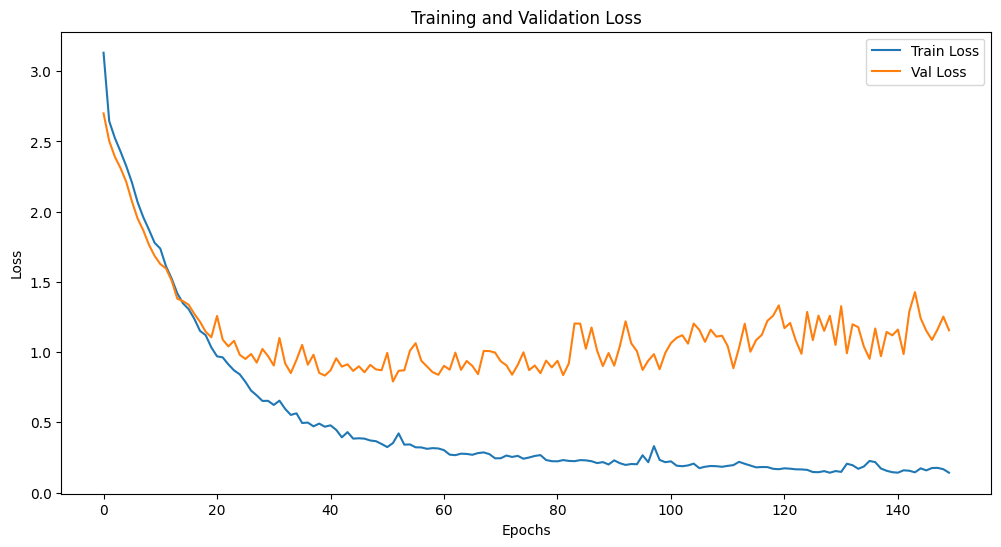

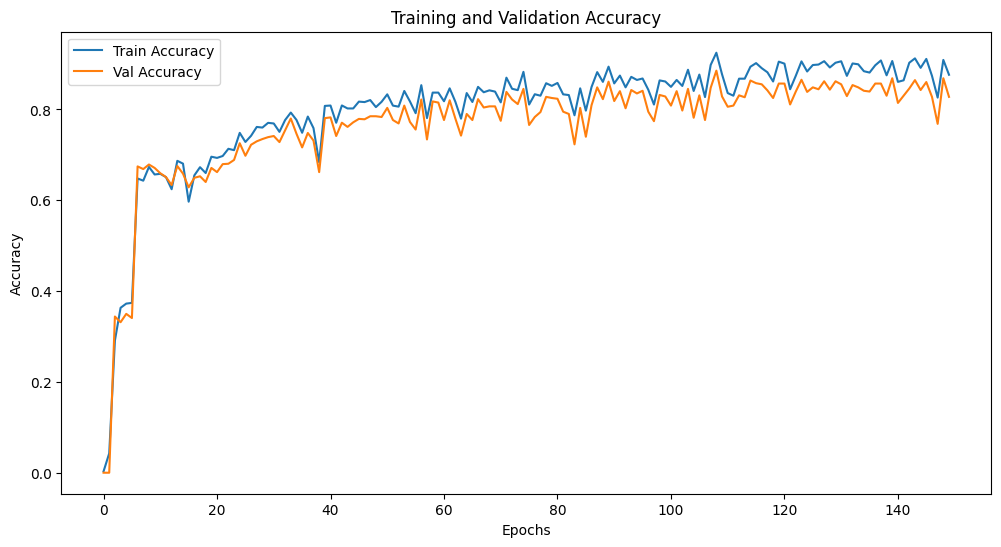

In [18]:
for seq, lbls in val_loader.dataset:
        preds = inference(model, seq, device, window_size)
        print(f"Preds: {preds.tolist()}  Truth: {lbls[window_size-1:].tolist()}")

# --- Evaluation on full validation set ---
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Remove seaborn dependency; use matplotlib for confusion matrix
import matplotlib.pyplot as plt

all_preds, all_truths = [], []
for seq, lbls in val_loader.dataset:
    preds = inference(model, seq, device, window_size)
    truths = lbls[window_size-1:].tolist()
    all_preds.extend(preds.tolist())
    all_truths.extend(truths)

acc = accuracy_score(all_truths, all_preds)
print(f"Validation Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(all_truths, all_preds, zero_division=0))
#show history train and val loss
plt.figure(figsize=(12, 6))
plt.plot(loss_hist['train_loss'], label='Train Loss')
plt.plot(loss_hist['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
#show history train and val acc
plt.figure(figsize=(12, 6))
plt.plot(loss_hist['train_acc'], label='Train Accuracy')
plt.plot(loss_hist['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')    
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [21]:
#take vide from data/datatest and inference mediapipe keypoints and inference model
def process_video(video_path, model, device, window_size=15):
    cap = cv2.VideoCapture(video_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps // 6)
    frame_count = 0
    if frame_interval == 0:
        frame_interval = 1
    if not cap.isOpened():
        raise IOError(f"Không mở được {video_path}")

    keypoints = np.zeros((window_size, 150), dtype=np.float32)  # Assuming 126 keypoints per frame
    results = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval != 0:
            frame_count += 1
            continue
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        _, result = pose.process_frame(image_rgb)
        frame_keypoints = pose.extract_keypoints(result)
        #add frame_keypoints to keypoints
        keypoints = np.vstack((keypoints, frame_keypoints))
        keypoints = np.array(keypoints[1:])
        seq_tensor = torch.from_numpy(keypoints).float().to(device)
        preds = inference(model, seq_tensor, device, window_size)
        preds = preds.cpu().numpy()
        results.append(preds[0])
        frame_count += 1
    cap.release()
    # Convert to tensor and perform inference
    return results

In [22]:
#take video from data/datatest
path = "data/datatest"
video_files = [f for f in os.listdir(path) if f.endswith('.mp4')]
for video_file in video_files:
    video_path = os.path.join(path, video_file)
    print(f"Processing video: {video_path}")
    results = process_video(video_path, model, device, window_size)
    print(f"Results for {video_file}: {results}")

Processing video: data/datatest/bộ đội.mp4


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 150 and the array at index 1 has size 2